# British Airways Forage Data Science Internship Project
## Task 1
The task for this project was to scrape and analyse customer reviews to uncover findings for British Airways.

Using the review website SkyTrax (https://www.airlinequality.com/) we can focus on just British Airways at (https://www.airlinequality.com/airline-reviews/british-airways/). 

## 1 Initialization 
First, we shall import all of the modules we will be using

In [1]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from textblob import TextBlob
from wordcloud import WordCloud
from string import digits
import numpy as np
import threading
import requests
import pandas as pd
import nltk
import string
import seaborn as sns
import re
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trebor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2 Scraping the website
Navigating the SkyTrax website's HTML shows that the reviews are stored under ```text_content```. We then use threads to scrape the first 300 pages of reviews. Threads can be run simultaneously and thus improve the efficiency of data collection. The data collected is saved as the 'review' and the corresponding 'date'. We also ensure that the script can handle any HTML errors.

The data is then saved in a .txt file for ease of use.

In [2]:
# Define the base URL and the number of pages to scrape
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/page/"
total_pages = 300
with open("british_airways_reviews.txt", "w", encoding="utf-8") as file:
    file.write("") #Overwrite any previously saved data    
# Function to scrape a single page and add reviews to the database
def scrape_page(page_num):
    url = f"{base_url}{page_num}/"
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        reviews = soup.find_all(class_="text_content")
        date_element = soup.find_all('time', itemprop='datePublished')
        with open(f"british_airways_reviews.txt", "a", encoding="utf-8") as file:
            for i in range(len(reviews)):
                review_text = reviews[i].get_text(strip=True)
                date = date_element[i]['datetime']
                file.write(review_text + "\t" + date + "\n")
        
        #print(f"Scraping page {page_num} successful.")
    else:
        print(f"Failed to scrape page {page_num}.")

# Define the number of threads to use
num_threads = 4  

# Create a list to hold thread objects
threads = []

# Start scraping using multiple threads
for page_num in range(1, total_pages + 1):
    # Create a new thread for each page
    thread = threading.Thread(target=scrape_page, args=(page_num,))
    threads.append(thread)
    thread.start()

# Wait for all threads to finish
for thread in threads:
    thread.join()


## 3 Cleaning and investigation of data
In this section, we will explore the data a bit more and see how we can clean it, make sure it is useful, and think of what we can do with it.

We start by reading the data file in as a Pandas dataframe and outputting the first 5 entries. This allows us to see where we need to tidy up the data.

In [46]:
df = pd.read_csv(f"british_airways_reviews.txt",sep='\t',names=['Review', 'Date'])
df.head()

,Review,Date
0,"Not Verified| Flight delayed by an hour, it h...",2023-08-12
1,Not Verified| The staff are very rude and not ...,2023-08-11
2,✅Trip Verified| Good domestic flight operated...,2023-08-08
3,Not Verified| Failed at all basic travel funda...,2023-08-08
4,✅Trip Verified| They lost my baggage in a ver...,2023-08-08


We can then use the describe function to see more information about the dataframe.

In [47]:
df.describe()

,Review,Date
count,3029,3000
unique,3005,1741
top,✅Verified Review|,2015-12-01
freq,11,9


From the .head(), we can see that the data consists of a section saying if it is verified or not, and then the actual review. This can be split up into two different tables in Panda.

In [48]:
df['Verified'] = df['Review'].apply(lambda x: x.split('|')[0])
df['Review'] = df['Review'].apply(lambda x: x.split('|', 1)[1].strip() if '|' in x else x)


We can then use .value_counts() to look at the unique entries of the verified field. This allows us to assign a binary indicator to the table.

In [49]:
unique_entries_counts = df['Verified'].value_counts()

for entry, count in unique_entries_counts.items():
    if len(entry) < 50:
        print(f"{entry}: {count} occurrences")

✅Trip Verified: 1262 occurrences
✅Verified Review: 770 occurrences
Not Verified: 271 occurrences
❎Unverified: 20 occurrences
❎Not Verified: 5 occurrences
    ⚑British Airways Ranking: 1 occurrences
non responsive airline.: 1 occurrences
cNot Verified: 1 occurrences


We then can use the unique entries shown above to group the verified and unverifed groups together in a binary system. 1 indicating that a review is verified, 0 indicating that it is not.

In [50]:
verified_reviews = ['✅Trip Verified', '✅Verified Review']
unverified_reviews = ['Not Verified', '❎Unverified', '❎Not Verified']
df['Review'] = df['Review'].str.strip()
df['Review'] = df['Review'].str.lower()
df = df[df['Verified'].isin(verified_reviews+unverified_reviews)]
df['Verified'] = df['Verified'].apply(lambda x: 1 if x in verified_reviews else 0)
df.head()


,Review,Date,Verified
0,"flight delayed by an hour, it happens, no bigg...",2023-08-12,0
1,the staff are very rude and not trained proper...,2023-08-11,0
2,good domestic flight operated by ba cityflyer....,2023-08-08,1
3,failed at all basic travel fundamentals: 1) ou...,2023-08-08,0
4,they lost my baggage in a very simple situatio...,2023-08-08,1


We can now further clean the data by removing 'stop words' that do not contribute to the sentiment of the review.

In [51]:
df['Review'] = df.apply(lambda row: nltk.word_tokenize(row['Review']), axis=1)
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x if word not in (stop_words)]))
df.head()


,Review,Date,Verified
0,"flight delayed hour , happens , biggie . us ch...",2023-08-12,0
1,staff rude trained properly . exceptions made ...,2023-08-11,0
2,good domestic flight operated ba cityflyer . g...,2023-08-08,1
3,failed basic travel fundamentals : 1 ) flight ...,2023-08-08,0
4,lost baggage simple situation . 's three weeks...,2023-08-08,1


We can now assign a sentiment score to each review to classify it as positive, negative or neutral.  

In [53]:
def seniment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None
    
def tag_cal(num):
    if num<-0.05:
        return 'Negative'
    elif num>0.05:
        return 'Positive'
    else:
        return 'Neutral'
        
    
df['Sentiment'] = df['Review'].apply(seniment_calc)


df['Tag'] = df['Sentiment'].apply(tag_cal)
df.head()

,Review,Date,Verified,Sentiment,Tag
0,"flight delayed hour , happens , biggie . us ch...",2023-08-12,0,0.225000,Positive
1,staff rude trained properly . exceptions made ...,2023-08-11,0,-0.300000,Negative
2,good domestic flight operated ba cityflyer . g...,2023-08-08,1,0.236111,Positive
3,failed basic travel fundamentals : 1 ) flight ...,2023-08-08,0,-0.265714,Negative
4,lost baggage simple situation . 's three weeks...,2023-08-08,1,0.037500,Neutral


We can now draw a histogram of the sentiment scores of reviews. This will help British Airways know, generally, how well their services are received. 

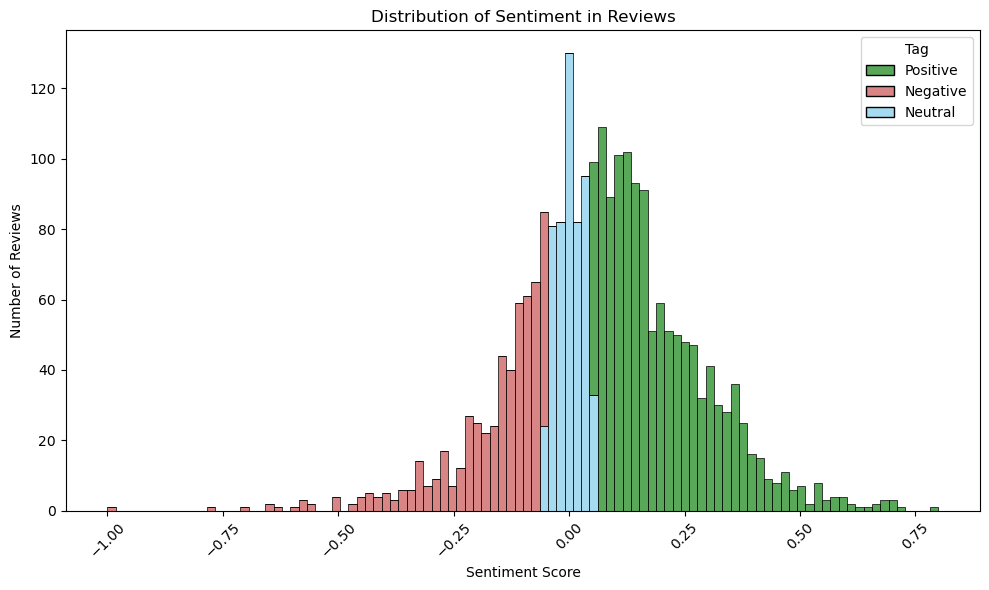

<Figure size 640x480 with 0 Axes>

In [54]:
plt.figure(figsize=(10, 6))

plot_ = sns.histplot(data=df, x='Sentiment', hue = 'Tag', multiple = "stack", bins=100, kde=False,palette={'Negative': 'indianred', 'Neutral': 'skyblue', 'Positive': 'forestgreen'} )

plt.xticks(rotation=45)
        
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment in Reviews')
plt.tight_layout()

# Show the histogram
plt.show()
plt.savefig("NumReview.png", dpi=200)

We could use this histogram to research specific reviews further, for example it is interesting (at least to me), that there is a review with a -1 sentiment score. However, knowing a single persons opinion is less useful to BA than the general public, and therefore I will not look any further into it at this time.

We now just look at the verified reviews, and sort by date.

In [55]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(axis = 0, how = 'any')
# Extract the month from the 'Date' column
df = df.sort_values('Date')

df.head()

,Review,Date,Verified,Sentiment,Tag
2599,gatwick amsterdam business class truly uncomfo...,2016-03-23,1,-0.023106,Neutral
2597,british airways seattle johannesburg via londo...,2016-03-23,1,0.087634,Positive
2481,"flown british airways 100 times , usually busi...",2016-03-24,1,0.089583,Positive
2480,"london heathrow houston british airways , frie...",2016-03-25,1,0.168056,Positive
2479,istanbul london heathrow british airways . mai...,2016-03-26,1,0.205128,Positive


It may be helpful to British Airways to know when the reviews are being sent in, if there are any patterns over time etc. 
To show this, a histogram of the frequency of reviews made month by month is created.

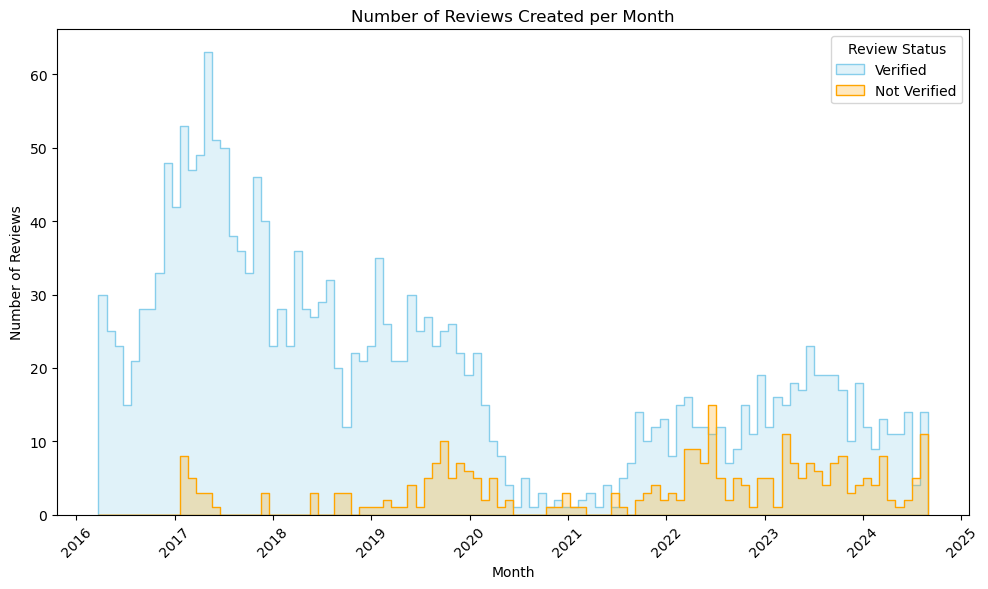

<Figure size 640x480 with 0 Axes>

In [57]:
plt.figure(figsize=(10, 6))
earliest_date = df['Date'].min()
latest_date = df['Date'].max()
# Calculate the range in months
months_range = (latest_date - earliest_date) // pd.Timedelta(days=30)
#plot_ = sns.histplot(data=new_df, x = 'Date', bins = months_range, kde=False, color='skyblue')
plot_ = sns.histplot(data=df, x='Date', hue='Verified', bins=months_range, kde=False, element="step", stat="count", common_norm=False, palette={0: 'orange', 1: 'skyblue'})
plot_.legend(title='Review Status', labels=['Verified', 'Not Verified'])

plt.xticks(rotation=45)
        
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Created per Month')
plt.tight_layout()

# Show the histogram
plt.show()
plt.savefig("NumReview.png", dpi=200)

Now focusing on the verfified reviews.

In [13]:
df = df[df['Verified']==1]

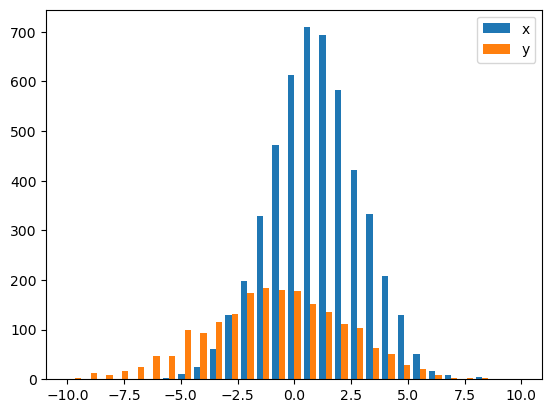

In [14]:

x = np.random.normal(1, 2, 5000)
y = np.random.normal(-1, 3, 2000)
bins = np.linspace(-10, 10, 30)

plt.hist([x, y], bins, label=['x', 'y'])
plt.legend(loc='upper right')
plt.show()

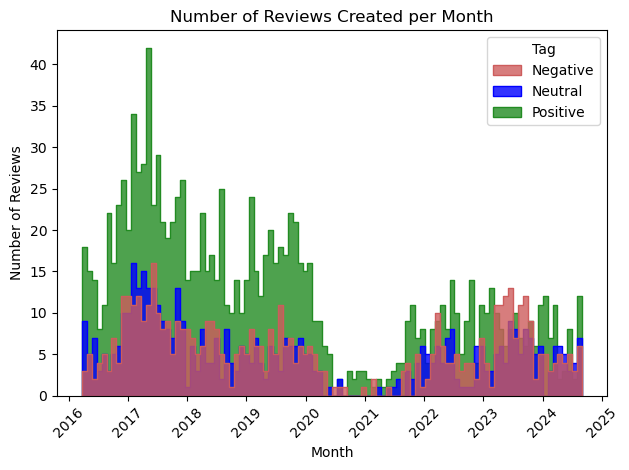

<Figure size 640x480 with 0 Axes>

In [66]:
# Plot histogram
plot_ = sns.histplot(
    data=df, 
    x='Date', 
    hue='Tag', 
    bins=months_range, 
    alpha=0.8,  # Slightly reduce transparency
    stat='count', 
    element="step",  # Add outlines around bars
    kde=False, 
    hue_order=['Negative', 'Neutral', 'Positive'],  # Set the order with Positive last
    palette={'Negative': 'indianred', 'Neutral': 'blue', 'Positive': 'forestgreen'}
)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Created per Month')

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the histogram
plt.show()

# Save the figure with a high DPI
plt.savefig("NumReview.png", dpi=200)


We can use this to quickly see that after the pandemic (the dip in total reviews), the proportion of negative to positive reviews has massively increased. This should be a point of concern to British Airways. 

This data can also be shown in a line chart, which may be easier to read (although I think it has a lot of white space)

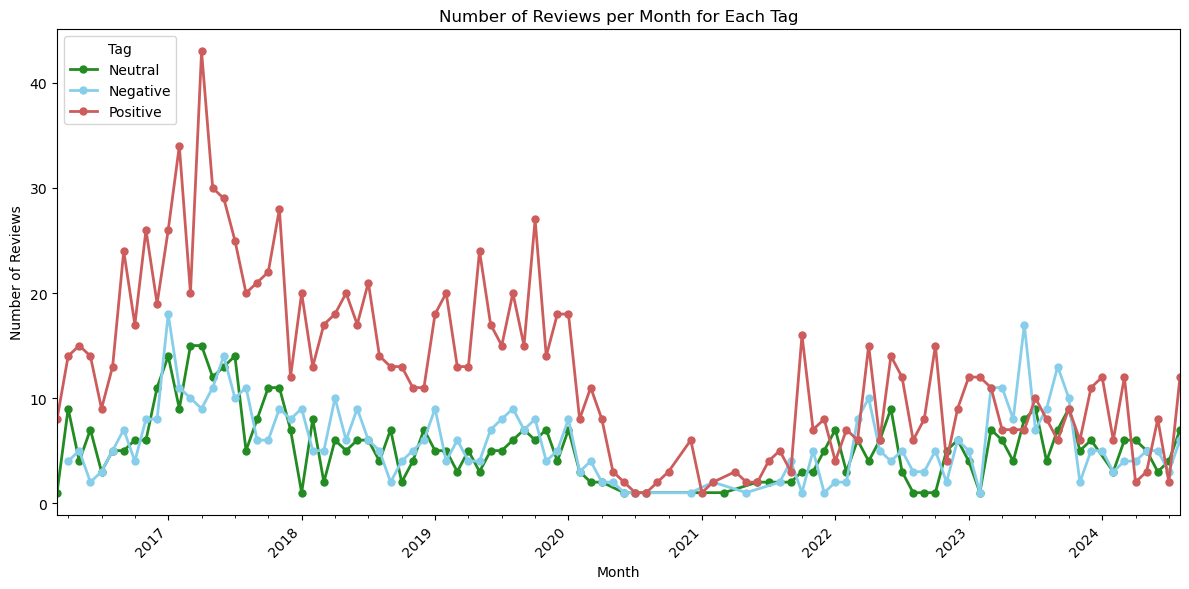

In [68]:
df['Month'] = df['Date'].dt.to_period('M')
tag_month_counts = df.groupby(['Tag', 'Month']).size().unstack(0)

# Plotting
plt.figure(figsize=(12, 6))

# Define the tags and corresponding colors
tags = ['Neutral', 'Negative', 'Positive']
colors = {'Neutral': 'forestgreen', 'Negative': 'skyblue', 'Positive': 'indianred'}

for tag in tags:
    reviews_counts = tag_month_counts[tag].dropna()
    reviews_counts.plot(style='o-', markersize=5, linewidth=2, color=colors[tag], label=tag)  # Set color and label

# Customize the plot
plt.title('Number of Reviews per Month for Each Tag')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Tag', loc='upper left')
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()


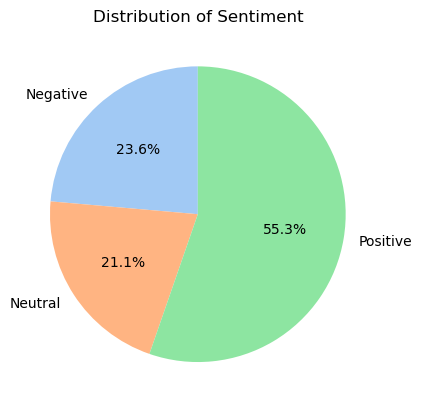

In [17]:
sentiment_percent = (df.groupby('Tag').size()/df['Tag'].count())*100
sns.set_palette("pastel")  # Optional: Set color palette
plt.pie(sentiment_percent, labels=sentiment_percent.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiment')

# Show the pie chart
plt.show()

Lastly, we can create WordClouds which show the most common words. This will help British Airways quickly determine what services they are praised and critised for.

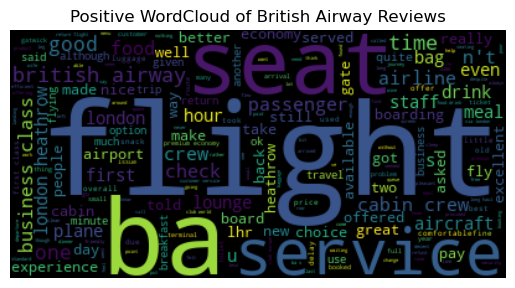

In [70]:
text = " "
for ind in df.index:
    if df['Tag'][ind] == "Positive":
        text = text + df['Review'][ind]
      
wordcloud_positive = WordCloud().generate(text)


# Display the generated image:
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title("Positive WordCloud of British Airway Reviews")
plt.axis("off")
plt.show()

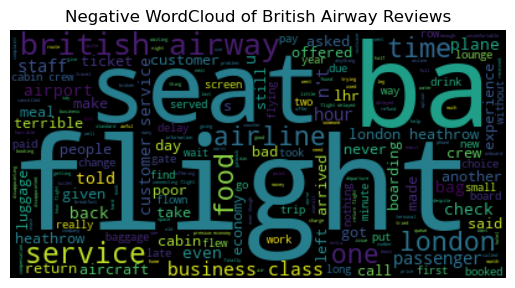

In [71]:
text2= " "        
for ind in df.index:
    if df['Tag'][ind] == "Negative":
        text2 = text2 + df['Review'][ind]  
wordcloud_negative = WordCloud().generate(text2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative WordCloud of British Airway Reviews")

plt.show()

This is all that British Airways was after, however I feel like there is a lot more that could be done here. The WordClouds, in their current state, are not too helpful. This is due to multiple vague, or repeated words such as flight, ba, british airways and service. It would be better if these were also removed (with the stopwords), making way for more specific words to be shown. Adjectives, such as terrible and good could also be removed as they provide no insight. If this were to be presented in a meeting, more care could be given to the design, spacing and format of the Wordcloud, such that it is clear to read. 